# UAS Dat Science Project

Dataset : Job Change of Data Scientists

Source : https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists/data

Features
*   enrollee_id : Unique ID for candidate.
*   city: City code.
*   city_ development _index : Developement index of the city (scaled).
*   gender: Gender of candidate
*   relevent_experience: Relevant experience of candidate
*   enrolled_university: Type of University course enrolled if any
*   education_level: Education level of candidate
*   major_discipline :Education major discipline of candidate
*   experience: Candidate total experience in years
*   company_size: No of employees in current employer's company
*   company_type : Type of current employer
*   last_new_job: Difference in years between previous job and current job
*   training_hours: training hours completed
*   target: 0 – Not looking for job change, 1 – Looking for a job change

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)

In [ ]:
# Load data
training_df = pd.read_csv('/content/aug_train.csv')
testing_df  = pd.read_csv('/content/aug_test.csv')

In [ ]:
training_df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [ ]:
training_df.shape

(19158, 14)

In [ ]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [ ]:
target = 'target'

training_df[target].value_counts(normalize=True)

,proportion
target,
0.0,0.750652
1.0,0.249348


## Data Preprocessing (Data Cleaning & Preparation)

In [ ]:
training_df = training_df.drop(columns=['enrollee_id'])
testing_df  = testing_df.drop(columns=['enrollee_id'])

In [ ]:
training_df.isnull().sum().sort_values(ascending=False)


,0
company_type,6140
company_size,5938
gender,4508
major_discipline,2813
education_level,460
last_new_job,423
enrolled_university,386
experience,65
city,0
relevent_experience,0


In [ ]:
# Pisahkan data numerik dan kategorikal
num_cols = ['city_development_index', 'training_hours']
cat_cols = [
    'gender', 'relevent_experience', 'enrolled_university',
    'education_level', 'major_discipline', 'company_size',
    'company_type'
]

# Mengisi NaN menggunakan median data
for col in num_cols:
    training_df[col].fillna(training_df[col].median(), inplace=True)
    testing_df[col].fillna(training_df[col].median(), inplace=True)

for col in cat_cols:
    training_df[col].fillna('Unknown', inplace=True)
    testing_df[col].fillna('Unknown', inplace=True)


/tmp/ipython-input-1736062551.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  training_df[col].fillna(training_df[col].median(), inplace=True)
/tmp/ipython-input-1736062551.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

In [ ]:
# Membersihkan dan mengonversi kolom experience dan last_new_job ke numerik

def clean_experience(x):
    if pd.isna(x):
        return 0
    if x == '>20':
        return 21
    if x == '<1':
        return 0
    if x == 'never':
        return 0
    return float(x)

def clean_last_job(x):
    if pd.isna(x):
        return 0
    if x == '>4':
        return 5
    if x == 'never':
        return 0
    return float(x)


training_df['experience'] = training_df['experience'].apply(clean_experience)
testing_df['experience']  = testing_df['experience'].apply(clean_experience)

training_df['last_new_job'] = training_df['last_new_job'].apply(clean_last_job)
testing_df['last_new_job']  = testing_df['last_new_job'].apply(clean_last_job)

In [ ]:
# Kolom khusus
training_df['experience'] = training_df['experience'].apply(clean_experience)
testing_df['experience']  = testing_df['experience'].apply(clean_experience)

training_df['last_new_job'] = training_df['last_new_job'].apply(clean_last_job)
testing_df['last_new_job']  = testing_df['last_new_job'].apply(clean_last_job)

In [ ]:
training_df.isnull().sum()

,0
city,0
city_development_index,0
gender,0
relevent_experience,0
enrolled_university,0
education_level,0
major_discipline,0
experience,0
company_size,0
company_type,0


In [ ]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  19158 non-null  float64
 2   gender                  19158 non-null  object 
 3   relevent_experience     19158 non-null  object 
 4   enrolled_university     19158 non-null  object 
 5   education_level         19158 non-null  object 
 6   major_discipline        19158 non-null  object 
 7   experience              19158 non-null  float64
 8   company_size            19158 non-null  object 
 9   company_type            19158 non-null  object 
 10  last_new_job            19158 non-null  float64
 11  training_hours          19158 non-null  int64  
 12  target                  19158 non-null  float64
dtypes: float64(4), int64(1), object(8)
memory usage: 1.9+ MB


In [ ]:
training_df.to_csv('train_clean.csv', index=False)
testing_df.to_csv('test_clean.csv', index=False)

## EDA (Exploratory Data Analysis)

In [ ]:
training_clean_df = pd.read_csv('train_clean.csv')

In [ ]:
training_clean_df['target'].value_counts()

,count
target,
0.0,14381
1.0,4777


In [ ]:
training_clean_df.isnull().sum()

,0
city,0
city_development_index,0
gender,0
relevent_experience,0
enrolled_university,0
education_level,0
major_discipline,0
experience,0
company_size,0
company_type,0


/tmp/ipython-input-3043700195.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=training_clean_df, palette='viridis')


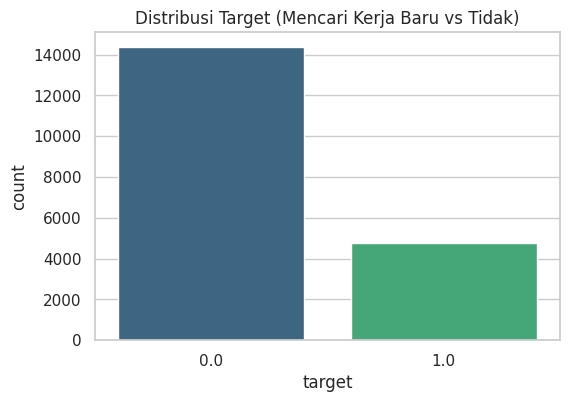

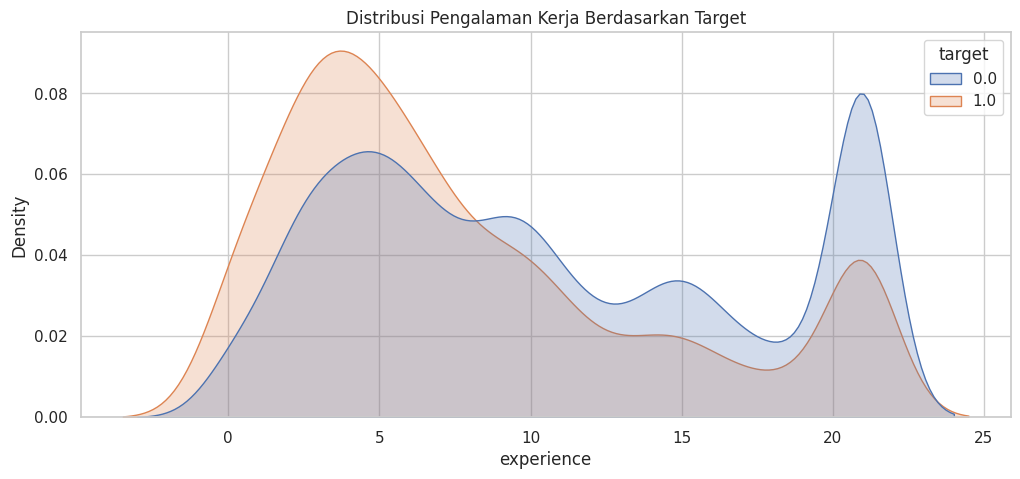

In [ ]:
# Set style visualisasi
sns.set(style="whitegrid")

# Visualisasi 1: Distribusi Target (Imbalance Check)
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=training_clean_df, palette='viridis')
plt.title('Distribusi Target (Mencari Kerja Baru vs Tidak)')
plt.show()

# Visualisasi 2: Hubungan Pengalaman Kerja dengan Target
plt.figure(figsize=(12, 5))
sns.kdeplot(data=training_clean_df, x='experience', hue='target', fill=True, common_norm=False)
plt.title('Distribusi Pengalaman Kerja Berdasarkan Target')
plt.show()

In [ ]:
pd.crosstab(
    training_clean_df['education_level'],
    training_clean_df['target'],
    normalize='index'
)


target,0.0,1.0
education_level,,
Graduate,0.720210,0.279790
High School,0.804660,0.195340
Masters,0.785600,0.214400
Phd,0.859903,0.140097
Primary School,0.866883,0.133117
Unknown,0.773913,0.226087


## Feature Engineering - Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Mapping Ordinal (Manual) - Untuk kolom yang punya tingkatan
education_map = {
    'Primary School': 0,
    'High School': 1,
    'Graduate': 2,
    'Masters': 3,
    'Phd': 4,
    'Unknown': -1
}

company_size_map = {
    'Unknown': 0, '<10': 1, '10/49': 2, '50-99': 3, '100-500': 4,
    '500-999': 5, '1000-4999': 6, '5000-9999': 7, '10000+': 8
}


In [ ]:
# Terapkan Mapping ke training_df
training_clean_df['education_level'] = training_clean_df['education_level'].map(education_map)
training_clean_df['company_size'] = training_clean_df['company_size'].map(company_size_map)

# Label Encoding (Otomatis) - Untuk kolom kategori biasa (Nominal)
le = LabelEncoder()
nominals = ['gender', 'city', 'relevent_experience', 'enrolled_university', 'major_discipline', 'company_type']

for col in nominals:
    training_clean_df[col] = le.fit_transform(training_clean_df[col].astype(str))

print("Encoding selesai pada training_df!")

Encoding selesai pada training_df!


In [ ]:
training_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  int64  
 1   city_development_index  19158 non-null  float64
 2   gender                  19158 non-null  int64  
 3   relevent_experience     19158 non-null  int64  
 4   enrolled_university     19158 non-null  int64  
 5   education_level         19158 non-null  int64  
 6   major_discipline        19158 non-null  int64  
 7   experience              19158 non-null  float64
 8   company_size            19158 non-null  int64  
 9   company_type            19158 non-null  int64  
 10  last_new_job            19158 non-null  float64
 11  training_hours          19158 non-null  int64  
 12  target                  19158 non-null  float64
dtypes: float64(4), int64(9)
memory usage: 1.9 MB


## Modeling

In [ ]:
# Split data menjadi training dan validation
# Tentukan fitur (X) dan target (y)
# Kita hapus kolom yang tidak dipakai untuk prediksi
X = training_clean_df.drop(['target'], axis=1)
y = training_clean_df['target']

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# from imblearn.over_sampling import SMOTE
# from collections import Counter

# # Inisialisasi SMOTE
# smote = SMOTE(random_state=42)

# # Terapkan SMOTE hanya pada data training
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# # Cek perbandingannya
# print(f"Sebelum SMOTE: {Counter(y_train)}")
# print(f"Sesudah SMOTE: {Counter(y_train_resampled)}")


In [ ]:
# Training Model menggunakan data hasil SMOTE
# rf_model_smote = RandomForestClassifier(
#     n_estimators=200,
#     max_depth=15, # Disarankan dibatasi agar tidak overfit data sintetis
#     min_samples_split=5,
#     random_state=42,
#     n_jobs=-1
# )

# rf_model_smote.fit(X_train_resampled, y_train_resampled)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Inisialisasi Model (Random Forest)
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

In [ ]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_val_pred = rf_model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Accuracy: 0.7925365344467641
              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86      2877
         1.0       0.58      0.63      0.60       955

    accuracy                           0.79      3832
   macro avg       0.72      0.74      0.73      3832
weighted avg       0.80      0.79      0.80      3832



In [ ]:
# from sklearn.metrics import accuracy_score, classification_report

# y_val_pred = rf_model_smote.predict(X_val)

# print("Accuracy:", accuracy_score(y_val, y_val_pred))
# print(classification_report(y_val, y_val_pred))


Accuracy: 0.785490605427975
              precision    recall  f1-score   support

         0.0       0.88      0.82      0.85      2877
         1.0       0.56      0.67      0.61       955

    accuracy                           0.79      3832
   macro avg       0.72      0.75      0.73      3832
weighted avg       0.80      0.79      0.79      3832



In [ ]:
import joblib

# 1. Simpan Model
joblib.dump(rf_model, 'model.pkl')

# 2. Simpan LabelEncoder
joblib.dump(le, 'label_encoder.pkl')

# 3. Simpan Mapping Ordinal
# Simpan dictionary mapping
joblib.dump(education_map, 'education_map.pkl')
print("✅ Model exported as model.pkl")

✅ Model exported as rf_model.pkl


## Visualization

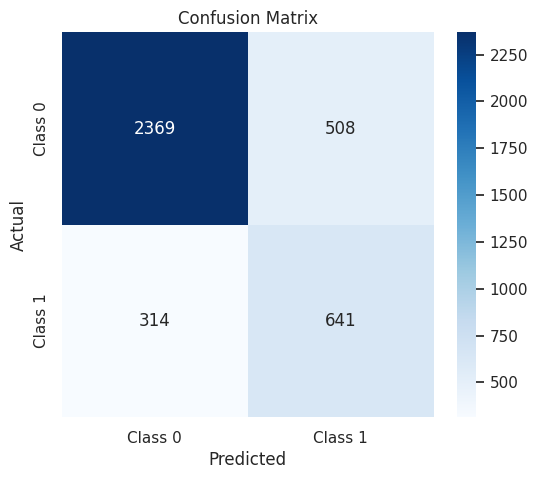

In [ ]:
# 1. Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0','Class 1'], yticklabels=['Class 0','Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

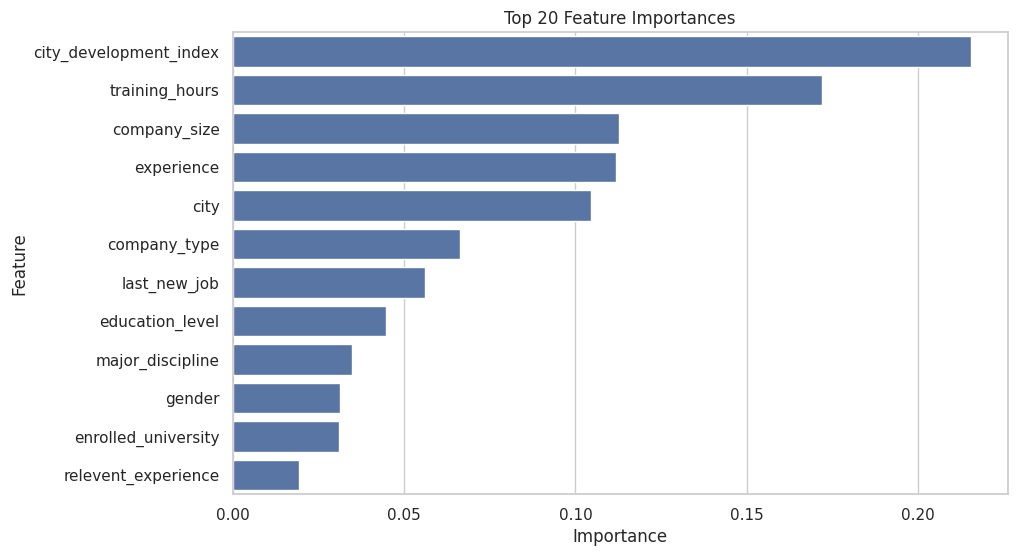

In [ ]:
# 2. Feature Importance
importances = rf_model.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values[:20], y=feat_imp.index[:20])
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


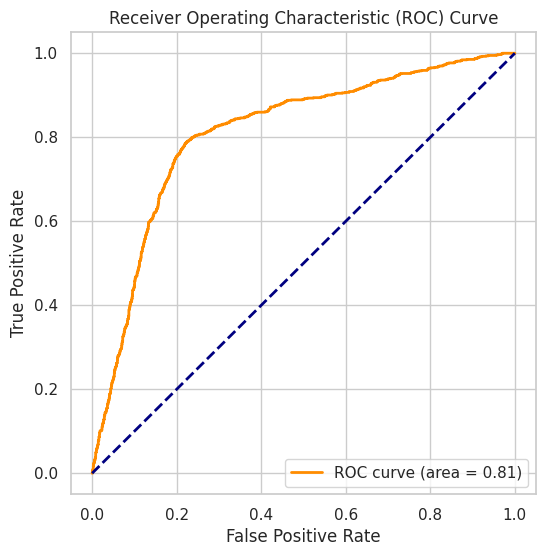

In [ ]:
# 3. ROC Curve (untuk binary classification)
if len(set(y)) == 2:
    y_val_prob = rf_model.predict_proba(X_val)[:,1]
    fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()